In [1]:
import torch
import sys, os
import pandas as pd
from tqdm.notebook import tqdm
import abmap
import numpy as np
import pickle
import matplotlib.pyplot as plt
from Bio import SeqIO

In [2]:
raw_dir = 'MITLL_AAlphaBio_Ab_Binding_dataset.csv'
df = pd.read_csv(raw_dir)
df.head()

,POI,Sequence,Target,Assay,Replicate,Pred_affinity,HC,LC,CDRH1,CDRH2,CDRH3,CDRL1,CDRL2,CDRL3
0,AAYL50_1332,EVQLVETGGGLVQPGGSLRLSCAASGFTLNSYGISWVRQAPGKGPE...,MIT_Target,1,1,0.866129,EVQLVETGGGLVQPGGSLRLSCAASGFTLNSYGISWVRQAPGKGPE...,DVVMTQSPESLAVSLGERATISCHSSQSVGYESRMKNSVAWYQQKA...,GFTLNSYGIS,VIYSDGRRTFYGDSVK,GRAAGTFDS,HSSQSVGYESRMKNSVA,WASTRES,QQYHRLPLS
1,AAYL50_20866,EVQLVETGGGLVQPGGSLRLSCAASGFTLNSYGISWVRQAPGKGPE...,MIT_Target,1,1,1.450543,EVQLVETGGGLVQPGGSLRLSCAASGFTLNSYGISWVRQAPGKGPE...,DVVMTQSPESLAVSLGERATISCKSSQSVLYESRNKVSVAWYQQKA...,GFTLNSYGIS,VIYSDGRRTFYGDSVK,GRAAGTFDS,KSSQSVLYESRNKVSVA,HANTRES,QQYHRLPLS
2,AAYL49_28,EVQLVETGGGLVQPGGSLRLSCAASNFTLQSYGISWVRQAPGKGPE...,MIT_Target,1,1,1.789996,EVQLVETGGGLVQPGGSLRLSCAASNFTLQSYGISWVRQAPGKGPE...,DVVMTQSPESLAVSLGERATISCKSSQSVLYESRNKNSVAWYQQKA...,NFTLQSYGIS,VIYSDGRRTFYGDSVK,GRAAGTFDS,KSSQSVLYESRNKNSVA,WASTRES,QQYHRLPLS
3,AAYL50_13317,EVQLVETGGGLVQPGGSLRLSCAASGFTLNSYGISWVRQAPGKGPE...,MIT_Target,1,1,1.704217,EVQLVETGGGLVQPGGSLRLSCAASGFTLNSYGISWVRQAPGKGPE...,DVVMTQSPESLAVSLGERATISCKSSQSVGYESRNKNSVAWYQQKA...,GFTLNSYGIS,VIYSDGRRTFYGDSVK,GRAAGTFDS,KSSQSVGYESRNKNSVA,VASTRAS,QQYHRLPLS
4,AAYL50_7657,EVQLVETGGGLVQPGGSLRLSCAASGFTLNSYGISWVRQAPGKGPE...,MIT_Target,1,1,1.625471,EVQLVETGGGLVQPGGSLRLSCAASGFTLNSYGISWVRQAPGKGPE...,DVVMTQSPESLAVSLGERATISCKSSESVLYQSRNKNSVAWYQQKA...,GFTLNSYGIS,VIYSDGRRTFYGDSVK,GRAAGTFDS,KSSESVLYQSRNKNSVA,WASTRES,QAYHRLPLS


In [3]:
df.Target.unique()

array(['MIT_Target', 'AlphaNeg2', 'AlphaNeg1', 'AlphaNeg3'], dtype=object)

In [4]:
print(len(df.POI.unique()), len(df.Sequence.unique()), len(df.HC.unique()), len(df.LC.unique()), df.shape)

104972 104968 48928 56043 (1259700, 14)


### Saving the sequences into fasta files

In [14]:
save_dir = ""
POI_set = set()
num_unique_ids = len(df.POI.unique())

for index, row in tqdm(df.iterrows(), total=df.shape[0]):

    if len(POI_set) == num_unique_ids:
        break
    
    if row['POI'] not in POI_set:
        seq_h, seq_l = row['HC'], row['LC']

        with open(os.path.join(save_dir, "sequences_H.fasta"), 'a') as outfile:
            outfile.write('>' + f"{row['POI']}_cat2_H_k100" + '\n')
            outfile.write(seq_h + '\n')
        with open(os.path.join(save_dir, "sequences_L.fasta"), 'a') as outfile:
            outfile.write('>' + f"{row['POI']}_cat2_L_k100" + '\n')
            outfile.write(seq_l + '\n')
        
        POI_set.add(row['POI'])
      

  0%|          | 0/1259700 [00:00<?, ?it/s]

### Calculating the labels for each sequence

In [ ]:
target = "MIT_Target"
poi_affinity_dict = dict()
for poi in tqdm(df.POI.unique()):
    df_poi = df.loc[(df['POI'] == poi) & (df['Target'] == target)]
    mean_affinity = df_poi["Pred_affinity"].mean()
    poi_affinity_dict[poi] = mean_affinity

### Calculating the number of mutations n for each sequence from its WT

In [19]:
MIT_95_H = "EVQLVESGAEVKKPGASVKVSCKASGYTFTSYGISWVRQAPGQGLEWMGWISAYNGNTNYAQKLQGRVTMTTDTSTSTAYMELRSLRSDDTAVYYCARVGRGVIDHWGQGTLVTVSS"
MIT_95_L = "SSELTQDPAVSVALGQTVRITCEGDSLRYYYANWYQQKPGQAPILVIYGKNNRPSGIADRFSGSNSGDTSSLIITGAQAEDEADYYCSSRDSSGFQVFFGAGTKLTVL"

MIT_91_H = "EVQLVESGGGLVQPGRSLRLSCAASGFTFDDYAMHWVRQAPGKGLEWVSGISWNSGSIGYADSVKGRFTISRDNAENSLYLQMNSLRAEDTALYYCAKVGRGGGYFDYWGQGTLVTVSS"
MIT_91_L = "QAVLTQPSSLSASPGASVSLTCTLRSGINVGTYRIYWYQQKPGSPPQYLLRYKSDSDKQQGSGVPSRFSGSKDASANAGILLISGLQSEDEADYYCMIWHSSAWVFGGGTKLTVL"

MIT_14_H = "EVQLVETGGGLVQPGGSLRLSCAASGFTLNSYGISWVRQAPGKGPEWVSVIYSDGRRTFYGDSVKGRFTISRDTSTNTVYLQMNSLRVEDTAVYYCAKGRAAGTFDSWGQGTLVTVSS"
MIT_14_L = "DVVMTQSPESLAVSLGERATISCKSSQSVLYESRNKNSVAWYQQKAGQPPKLLIYWASTRESGVPDRFSGSGSGTDFTLTISSLQAEDAAVYYCQQYHRLPLSFGGGTKVEIK"

In [20]:
def diff_seq(seq1, seq2):
    count = 0
    for i in range(len(seq1)):
        if seq1[i] != seq2[i]:
            count += 1
    return count

In [21]:
num_mutations_dict = dict()

for index, row in tqdm(df.iterrows(), total=df.shape[0]):
    if row['POI'] in num_mutations_dict:
        continue
    
    if 'AAYL49' in row['POI']:
        num_muts = diff_seq(MIT_14_H, row['HC'])
    elif 'AAYL50' in row['POI']:
        num_muts = diff_seq(MIT_14_L, row['LC'])
    elif 'AAYL51' in row['POI']:
        num_muts = diff_seq(MIT_91_H, row['HC'])
    elif 'AAYL52' in row['POI']:
        num_muts = diff_seq(MIT_95_L, row['LC'])
    elif 'MIT' in row['POI']:
        num_muts = 0
    
    if num_muts == 0:
        print(f"No mutations: {row['POI']}")
    
    num_mutations_dict[row['POI']] = num_muts

  0%|          | 0/1259700 [00:00<?, ?it/s]

No mutations: AAYL50_1
No mutations: MIT_14_HL_scFV
No mutations: MIT_91_LH_scFV
No mutations: MIT_95_HL_scFV
No mutations: AAYL49_29236
No mutations: AAYL52_1
No mutations: AAYL51_1


In [ ]:
save_dir = ""
with open(os.path.join(save_dir, 'num_mutations.p'), 'wb') as f:
    pickle.dump(num_mutations_dict, f)

(array([7.0000e+00, 0.0000e+00, 0.0000e+00, 2.2150e+03, 0.0000e+00,
        0.0000e+00, 1.4036e+04, 0.0000e+00, 0.0000e+00, 8.8714e+04]),
 array([0. , 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3. ]),
 <BarContainer object of 10 artists>)

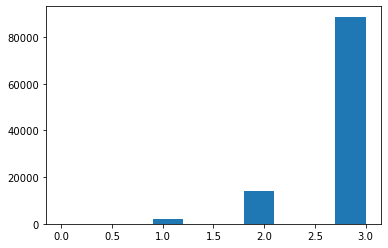

In [11]:
plt.hist(num_mutations_dict.values())

## Visualization of AlphaSeq sequences using AbMAP

### Embedding the sequences from scratch using pre-trained AbMAP and saving data

In [10]:
from abmap import abmap_embed_batch

device = 2
plm_type = 'esm2'
alphaseq_inputs = ""
pretrained_path_H = ""
pretrained_path_L = ""
dev = torch.device(f'cuda:{device}' if torch.cuda.is_available() else "cpu")

abmap_H = abmap.load_abmap(pretrained_path=pretrained_path_H, plm_name=plm_type, device=device)
abmap_L = abmap.load_abmap(pretrained_path=pretrained_path_L, plm_name=plm_type, device=device)

root_dir = ""
with open(os.path.join(root_dir, 'mean_affinity_values.p'), 'rb') as p:
    affin_dict = pickle.load(p)

alphaseq_embeds_H, alphaseq_embeds_L = [], []
pois, mean_affins = [], []
for poi in tqdm(df.POI.unique()):
    pois.append(poi)
    for chain in ['H', 'L']:
        fname = f"{poi}_cat2_{chain}_k100.p"
        fname_ = os.path.join(alphaseq_inputs, fname)
        with open(fname_, 'rb') as p:
            input_embed = pickle.load(p).to(dev)
        input_embed = torch.unsqueeze(input_embed, 0)
        
        if chain == 'H':
            with torch.no_grad():
                embedding = abmap_H.embed(input_embed, embed_type='fixed')
            embedding = torch.squeeze(embedding, 0)
            alphaseq_embeds_H.append(embedding)
        else:
            with torch.no_grad():
                embedding = abmap_L.embed(input_embed, embed_type='fixed')
            embedding = torch.squeeze(embedding, 0)
            alphaseq_embeds_L.append(embedding)
        
    mean_affin = affin_dict[poi]
    mean_affins.append(mean_affin)
        
alphaseq_feats_H = torch.stack(alphaseq_embeds_H, dim=0).detach().cpu().numpy()
alphaseq_feats_L = torch.stack(alphaseq_embeds_L, dim=0).detach().cpu().numpy()

save_dir = ""
with open(os.path.join(save_dir, f"052623_features_{plm_type}.p"), 'wb') as f:
    out = {'H_features': alphaseq_feats_H, 'L_features': alphaseq_feats_L, 
           'POIs': pois, 'mean_affinities': mean_affins}
    pickle.dump(out, f)
    

esm2 loaded to cuda:2


Using cache found in /afs/csail.mit.edu/u/c/chihoim/.cache/torch/hub/facebookresearch_esm_main


Loaded the Pre-trained Model!
esm2 loaded to cuda:2


Using cache found in /afs/csail.mit.edu/u/c/chihoim/.cache/torch/hub/facebookresearch_esm_main


Loaded the Pre-trained Model!


  0%|          | 0/104972 [00:00<?, ?it/s]

### Loading the saved AbMAP features and labels:

In [5]:
save_dir = ""
with open(os.path.join(save_dir, '052623_features_esm1b.p'), 'rb') as f:
    data = pickle.load(f)
    alphaseq_H_feats, alphaseq_L_feats = data['H_features'], data['L_features']
    POIs, mean_affins = data['POIs'], data['mean_affinities']

In [6]:
print(len(alphaseq_H_feats), len(alphaseq_L_feats), len(POIs), len(mean_affins))

104972 104972 104972 104972


In [7]:
print(POIs.index("MIT_14_HL_scFV")) #27069
WT_embed = np.concatenate((alphaseq_H_feats[27069:27069+1], alphaseq_L_feats[27069:27069+1]), axis=-1)
WT_embed.shape

27069


(1, 1024)

In [8]:
# for DDG calculation:
root_dir = ""
with open(os.path.join(root_dir, 'mean_affinity_values.p'), 'rb') as p:
    affin_dict = pickle.load(p)

# IMPORTANT: Remove entries with NaN affinity values (not present in dataset)
mask = ~np.isnan(mean_affins)
valid_idxs = np.where(mask)[0]

alphaseq_H_feats = alphaseq_H_feats[valid_idxs]
alphaseq_L_feats = alphaseq_L_feats[valid_idxs]
POIs = [POIs[i] for i in valid_idxs]
mean_affins = np.array([mean_affins[i] for i in valid_idxs])

# calculate DDGs here:
ddgs = []
for POI, mean_affin in zip(POIs, mean_affins):
    if "AAYL49" in POI:
        ddgs.append(mean_affin - affin_dict["AAYL49_29236"])
    elif "AAYL50" in POI:
        ddgs.append(mean_affin - affin_dict["AAYL50_1"])
    elif "AAYL51" in POI:
        ddgs.append(mean_affin - affin_dict["AAYL51_1"])
    elif "AAYL52" in POI:
        ddgs.append(mean_affin - affin_dict["AAYL52_1"])
    elif "MIT" in POI:
        ddgs.append(0.0)

ddgs = np.array(ddgs)

seed_names = [a[:6] for a in POIs]

In [9]:
alphaseq_feats = np.concatenate((alphaseq_H_feats, alphaseq_L_feats), axis=-1)
print(len(alphaseq_feats), len(alphaseq_H_feats), len(alphaseq_L_feats), len(POIs), len(mean_affins), len(ddgs))

71834 71834 71834 71834 71834 71834


### UMAP Projection

In [10]:
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style='white', context='notebook', rc={'figure.figsize':(14,10)})

In [11]:
# try a umap projection:
import umap
reducer = umap.UMAP()

alphaseq_feats = np.concatenate((alphaseq_H_feats, alphaseq_L_feats), axis=-1)

umap_proj = reducer.fit_transform(alphaseq_feats)
umap_proj.shape

(71834, 2)

### Sort the labels for better visualization

In [12]:
# mean_affins, seed_names, umap_proj = (list(t) for t in zip(*sorted(zip(mean_affins, seed_names, umap_proj), key=lambda x: x[0])))
seed_names, ddgs, umap_proj = (list(t) for t in zip(*sorted(zip(seed_names, ddgs, umap_proj), key=lambda x: x[0])))

umap_proj = np.array(umap_proj)

In [13]:
print(seed_names[-3:])

['MIT_14', 'MIT_91', 'MIT_95']


### Plot

Text(0.5, 1.0, 'UMAP projection of the AlphaSeq dataset with AbMAP (ddG)')

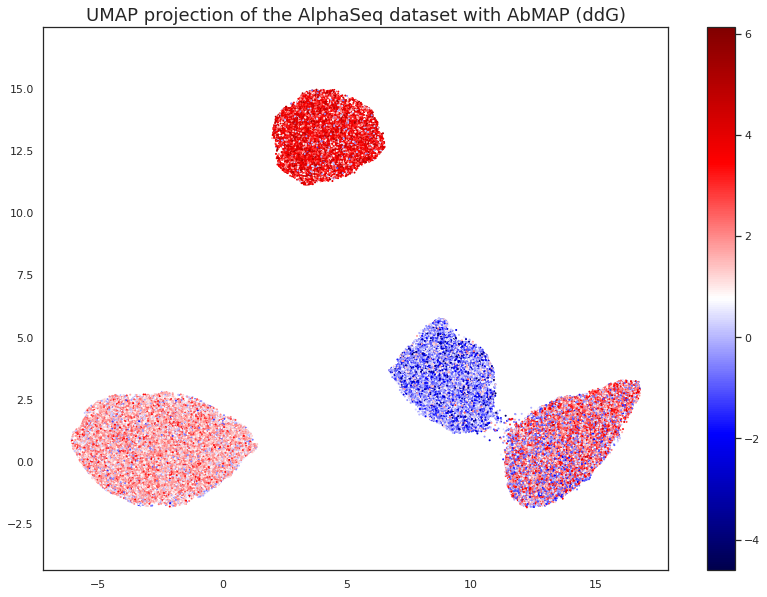

In [14]:
plt.scatter(umap_proj[:, 0],
            umap_proj[:, 1],
            s=1,
            c=ddgs,
            cmap=sns.color_palette("seismic", as_cmap = True))
plt.gca().set_aspect('equal', 'datalim')
plt.colorbar()
plt.title('UMAP projection of the AlphaSeq dataset with AbMAP (ddG)', fontsize=18)

(array([  160.,  2028.,  5850.,  7668., 10960., 15920., 16509.,  9938.,
         2623.,   178.]),
 array([-0.89063934, -0.10039673,  0.68984589,  1.4800885 ,  2.27033112,
         3.06057373,  3.85081635,  4.64105896,  5.43130157,  6.22154419,
         7.0117868 ]),
 <BarContainer object of 10 artists>)

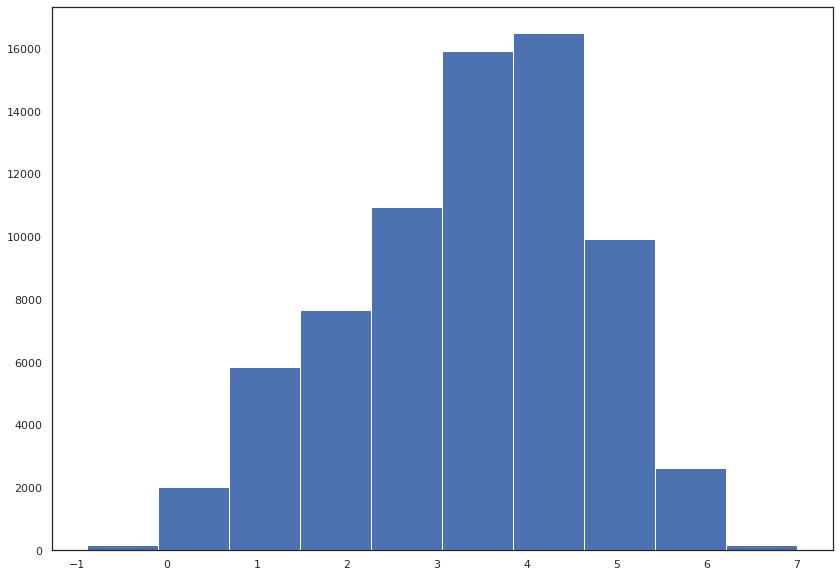

In [14]:
plt.hist(mean_affins)

(array([  206.,  1132.,  2592.,  9857., 16813., 17469., 11490.,  7860.,
         4114.,   301.]),
 array([-4.60676641, -3.53256461, -2.4583628 , -1.38416099, -0.30995919,
         0.76424262,  1.83844442,  2.91264623,  3.98684803,  5.06104984,
         6.13525164]),
 <BarContainer object of 10 artists>)

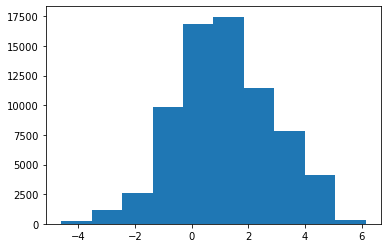

In [46]:
plt.hist(ddgs)

[<matplotlib.collections.PathCollection object at 0x7f09ee148ad0>, <matplotlib.collections.PathCollection object at 0x7f09edc75bd0>, <matplotlib.collections.PathCollection object at 0x7f09edc75890>, <matplotlib.collections.PathCollection object at 0x7f09edaf4dd0>]
['AAYL49', 'AAYL50', 'AAYL51', 'AAYL52']


Text(0.5, 1.0, 'UMAP projection of the AlphaSeq dataset with AbMAP (library)')

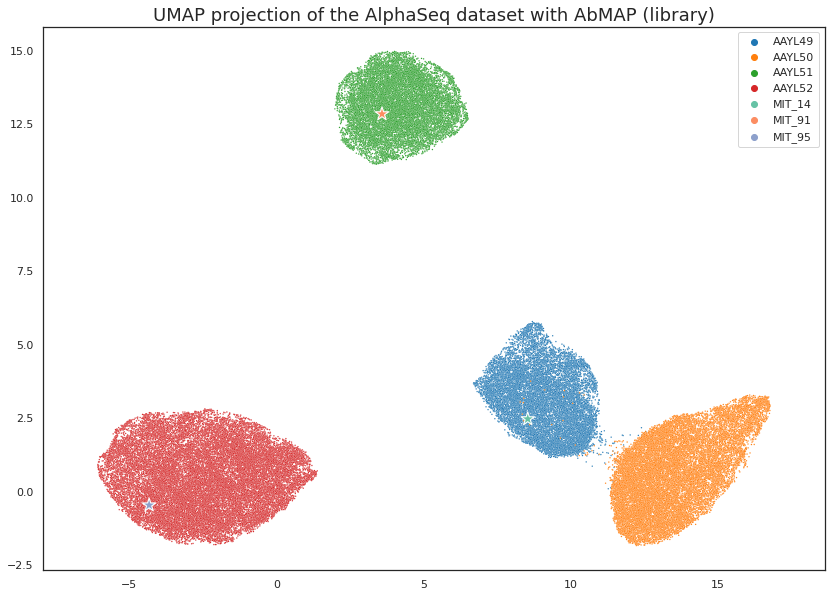

In [15]:
ax = sns.scatterplot(x=umap_proj[:-3, 0], y=umap_proj[:-3, 1], hue=seed_names[:-3], s=2, palette='tab10')
handles, labels = ax.get_legend_handles_labels()
print(handles)
print(labels)
                                                                              
ax2 = sns.scatterplot(x=umap_proj[-3:, 0], y=umap_proj[-3:, 1], hue=seed_names[-3:], marker="*", s=200, palette='Set2')
handles2, labels2 = ax2.get_legend_handles_labels()

plt.gca().set_aspect('equal', 'datalim')
plt.legend()
plt.title('UMAP projection of the AlphaSeq dataset with AbMAP (library)', fontsize=18)

(array([1.3922e+04, 1.8708e+04, 0.0000e+00, 1.3512e+04, 0.0000e+00,
        2.5689e+04, 1.0000e+00, 0.0000e+00, 1.0000e+00, 1.0000e+00]),
 array([0. , 0.6, 1.2, 1.8, 2.4, 3. , 3.6, 4.2, 4.8, 5.4, 6. ]),
 <BarContainer object of 10 artists>)

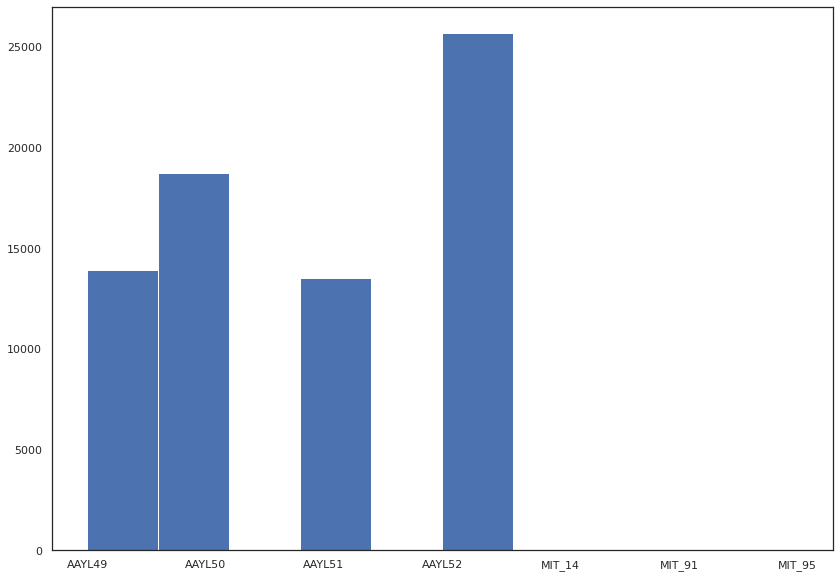

In [30]:
plt.hist(seed_names)

# Regression for Predicting Binding Affinity

In [10]:
import numpy as np
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV, Ridge, RidgeCV
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score, confusion_matrix
import seaborn as sns
from scipy.stats import spearmanr

## Ridge Regression

### Load the whole dataset (H+L concatenated)

In [60]:
# Load the whole dataset
alphaseq_feats = np.concatenate((alphaseq_H_feats, alphaseq_L_feats), axis=-1)
# X, y = alphaseq_feats, mean_affins
X, y = alphaseq_feats, ddgs
print("Dataset size:", X.shape, len(y))

Dataset size: (71834, 1024) 71834


### Load the whole dataset (either H or L accordingly to library)

In [19]:
out_features = []
for i in range(len(POIs)):
    poi = POIs[i]
    if 'AAYL49' in poi or 'AAYL51' in poi:
        out_features.append(alphaseq_H_feats[i])
    elif 'AAYL50' in poi or 'AAYL52' in poi:
        out_features.append(alphaseq_L_feats[i])
    else:
        out_features.append(alphaseq_H_feats[i])
        
out_features = np.stack(out_features)
X, y = out_features, mean_affins
print("Dataset size:", X.shape, len(y))

Dataset size: (71834, 512) 71834


### Isolate each library

In [57]:
library = 'AAYL52'
indices = [i for i, element in enumerate(POIs) if library in element]
X = alphaseq_feats[indices]
y = [ddgs[i] for i in indices]
print("Dataset size:", X.shape, len(y))

Dataset size: (25689, 1024) 25689


### Random Split (RidgeCV)

Spearman Correlation: 0.7242610903886538
Best Alpha: 0.01
R^2 Score: 0.5572713232063606


/data/cb/rsingh/miniconda3/envs/antibody_a100/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


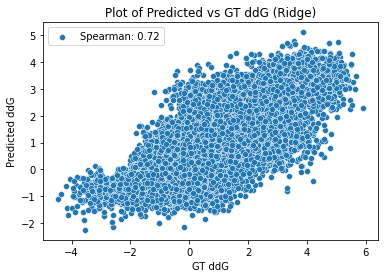

In [61]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)

# Create a RidgeCV regression model
ridge_model = RidgeCV(alphas=(0.01, 0.1, 0.5, 1.0, 10.0), cv=5)

# Train the model on the training data
ridge_model.fit(X_train, y_train)

y_pred = ridge_model.predict(X_test)
r2_score = ridge_model.score(X_test, y_test)

spearman_corr, p_value = spearmanr(y_test, y_pred)
print("Spearman Correlation:", spearman_corr)
print("Best Alpha:", ridge_model.alpha_)
print("R^2 Score:", r2_score)

sns.scatterplot(y_test, y_pred, label=f"Spearman: {spearman_corr:.2f}")
plt.xlabel('GT ddG')
plt.ylabel('Predicted ddG')
plt.title(f"Plot of Predicted vs GT ddG (Ridge)")
plt.show()

In [59]:
# compute top-k hits

k = 10
CUTOFF = 1.0

sorted_triplets = sorted(zip(y_pred, y_test))
topk_preds = [t[0] for t in sorted_triplets][:k]
topk_labels = [t[1] for t in sorted_triplets][:k]

# print(topk_preds)
# print(topk_labels)

hit_score = sum(i < CUTOFF for i in topk_labels)

print("Hit Ratio for top {}: {}/{}".format(k, hit_score, len(topk_preds)))

Hit Ratio for top 10: 10/10


### Biased Split (Fitting on high Kd value to test on low Kd value)

In [59]:
X, y = (list(t) for t in zip(*sorted(zip(X, y), key=lambda x: x[1], reverse=True)))

X = np.array(X)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Create a Ridge regression model
ridge_model = Ridge(alpha=0.1)

# Train the model on the training data
ridge_model.fit(X_train, y_train)

score = ridge_model.score(X_test, y_test)
print("R^2 score:", score)

R^2 score: -9.864606583320544


### ------------------------------------------------------------------------------------------------------------

## Logistic Regression

In [20]:
CUTOFF = 2.0
LIBRARY = 'AAYL50'

### Load the whole dataset (H+L concatenated)

In [21]:
# Load the whole dataset
alphaseq_feats = np.concatenate((alphaseq_H_feats, alphaseq_L_feats), axis=-1)
bind_labels = [1 if a <= CUTOFF else 0 for a in mean_affins]

X, y = alphaseq_feats, mean_affins
print("Dataset size:", X.shape, len(y))
print(f"Labels - Positive: {sum(bind_labels)}, Negative: {len(bind_labels) - sum(bind_labels)}")

Dataset size: (71834, 1024) 71834
Labels - Positive: 12785, Negative: 59049


Affinity Cutoff (log nM): 1.0
Library: AAYL50
Best C: [10.]
Sensitivity: 0.018137847642079808
Specificity: 0.9991875923190546
AUPR: 0.31981790125829596
AUROC: 0.8518813886571921


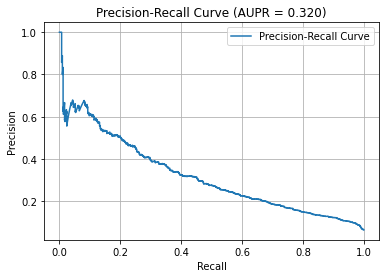

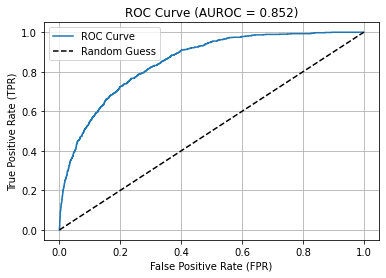

In [18]:
# Load your dataset and split it into training and testing sets
# X: feature matrix, y: target variable
X_train, X_test, y_train_, y_test_, POIs_train, POIs_test = train_test_split(X, y, POIs, test_size=0.2, random_state=7)


# ----- isolate each library --------
# X_train = [a for a, b in zip(X_train, POIs_train) if LIBRARY in b]
# X_test = [a for (a, b) in zip(X_test, POIs_test) if LIBRARY in b]
# y_train_ = [a for (a, b) in zip(y_train_, POIs_train) if LIBRARY in b]
# y_test_ = [a for (a, b) in zip(y_test_, POIs_test) if LIBRARY in b]
# POIs_train = [a for a in POIs_train if LIBRARY in a]
# POIs_test = [a for a in POIs_test if LIBRARY in a]
# -----------------------------------


# change the affinity to labels:
y_train = [1 if a <= CUTOFF else 0 for a in y_train_]
y_test = [1 if a <= CUTOFF else 0 for a in y_test_]

# Define the regularization parameter values to evaluate
Cs = [0.001, 0.01, 0.1, 1, 10]

# Define the logistic regression model with cross-validation
logreg_cv = LogisticRegressionCV(Cs=Cs, cv=5, max_iter=1000)

# Fit the logistic regression model on the training data
logreg_cv.fit(X_train, y_train)

# Predict the probabilities for the test set
y_pred_prob = logreg_cv.predict_proba(X_test)[:, 1]

# Compute the sensitivity and specificity
y_pred = logreg_cv.predict(X_test)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)

# Compute the ROC curve and AUROC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
auroc = auc(fpr, tpr)

# print(f"fpr: {fpr}, tpr: {tpr}")

# Compute the precision-recall curve and AUPR
precision, recall, _ = precision_recall_curve(y_test, y_pred_prob)
aupr = average_precision_score(y_test, y_pred_prob)

# Print the results
print("Affinity Cutoff (log nM):", CUTOFF)
print("Library:", LIBRARY)
print("Best C:", logreg_cv.C_)
print("Sensitivity:", sensitivity)
print("Specificity:", specificity)
print("AUPR:", aupr)
print("AUROC:", auroc)

# Plot the precision-recall curve
plt.plot(recall, precision, label='Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve (AUPR = {:.3f})'.format(aupr))
plt.legend()
plt.grid(True)
plt.show()

# Plot the roc curve
plt.plot(fpr, tpr, label='ROC Curve')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title("ROC Curve (AUROC = {:.3f})".format(auroc))
plt.legend()
plt.grid(True)
plt.show()

## Random Forest Classifier

Affinity Cutoff (log nM): 2.0
Library: AAYL50
Sensitivity: 0.1336206896551724
Specificity: 0.984934405416843
AUPR: 0.46575458868865766
AUROC: 0.7889271581075541


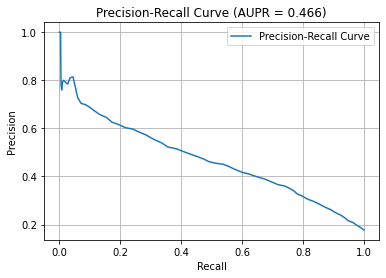

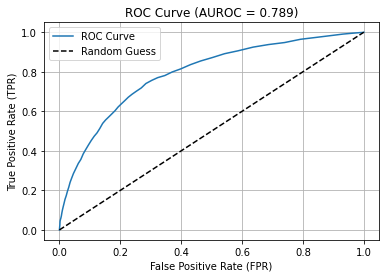

In [22]:
# Load your dataset and split it into training and testing sets
# X: feature matrix, y: target variable
X_train, X_test, y_train_, y_test_, POIs_train, POIs_test = train_test_split(X, y, POIs, test_size=0.2, random_state=7)


# ----- isolate each library --------
# X_train = [a for a, b in zip(X_train, POIs_train) if LIBRARY in b]
# X_test = [a for (a, b) in zip(X_test, POIs_test) if LIBRARY in b]
# y_train_ = [a for (a, b) in zip(y_train_, POIs_train) if LIBRARY in b]
# y_test_ = [a for (a, b) in zip(y_test_, POIs_test) if LIBRARY in b]
# POIs_train = [a for a in POIs_train if LIBRARY in a]
# POIs_test = [a for a in POIs_test if LIBRARY in a]
# -----------------------------------


# change the affinity to labels:
y_train = [1 if a <= CUTOFF else 0 for a in y_train_]
y_test = [1 if a <= CUTOFF else 0 for a in y_test_]

# Create an instance of the Random Forest Classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)

# Fit the logistic regression model on the training data
rf_classifier.fit(X_train, y_train)

# Predict the probabilities for the test set
y_pred_prob = rf_classifier.predict_proba(X_test)[:, 1]

# Compute the sensitivity and specificity
y_pred = rf_classifier.predict(X_test)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)

# Compute the ROC curve and AUROC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
auroc = auc(fpr, tpr)

# print(f"fpr: {fpr}, tpr: {tpr}")

# Compute the precision-recall curve and AUPR
precision, recall, _ = precision_recall_curve(y_test, y_pred_prob)
aupr = average_precision_score(y_test, y_pred_prob)

# Print the results
print("Affinity Cutoff (log nM):", CUTOFF)
print("Library:", LIBRARY)
print("Sensitivity:", sensitivity)
print("Specificity:", specificity)
print("AUPR:", aupr)
print("AUROC:", auroc)

# Plot the precision-recall curve
plt.plot(recall, precision, label='Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve (AUPR = {:.3f})'.format(aupr))
plt.legend()
plt.grid(True)
plt.show()

# Plot the roc curve
plt.plot(fpr, tpr, label='ROC Curve')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title("ROC Curve (AUROC = {:.3f})".format(auroc))
plt.legend()
plt.grid(True)
plt.show()

#### Plot of Probability Estimates vs Affinity Scores

In [47]:
y_test_2, y_pred_prob2 = y_test_, y_pred_prob

In [52]:
y_pred_prob_gm = (y_pred_prob1 * y_pred_prob2)**0.5
# y_pred_prob_min = [min(a, b) for a, b in zip(y_pred_prob1, y_pred_prob2)]

/data/cb/rsingh/miniconda3/envs/antibody_a100/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


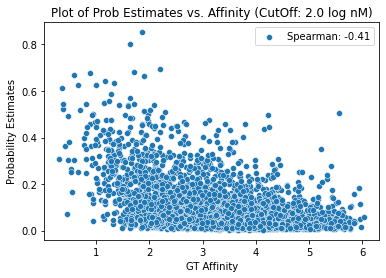

In [121]:
spearman_corr, p_value = spearmanr(y_test_, y_pred_prob)
# spearman_corr, p_value = spearmanr(y_test_, y_pred_prob_gm)
# spearman_corr, p_value = spearmanr(y_test_, y_pred_prob_min)

# Plot the curve
sns.scatterplot(y_test_, y_pred_prob, label=f"Spearman: {spearman_corr:.2f}")
# sns.scatterplot(y_test_, y_pred_prob_gm, label=f"Spearman: {spearman_corr:.2f}")
# sns.scatterplot(y_test_, y_pred_prob_min, label=f"Spearman: {spearman_corr:.2f}")
plt.xlabel('GT Affinity')
plt.ylabel('Probability Estimates')
plt.title(f"Plot of Prob Estimates vs. Affinity (CutOff: {CUTOFF} log nM)")
# plt.title(f"Plot of Prob Estimates vs. Affinity (Geometric Mean)")
# plt.title(f"Plot of Prob Estimates vs. Affinity (min(10nM, 100nM))")
plt.show()

#### Compute top-k hits (k = 10, 50)

Hit Ratio for top 10: 9/10


(array([ 0.,  0.,  0.,  0.,  0., 10.,  0.,  0.,  0.,  0.]),
 array([-0.5, -0.4, -0.3, -0.2, -0.1,  0. ,  0.1,  0.2,  0.3,  0.4,  0.5]),
 <BarContainer object of 10 artists>)

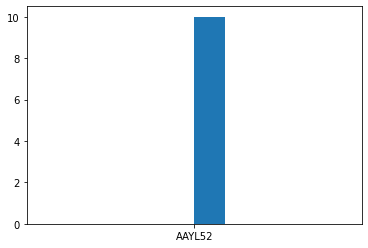

In [172]:
k = 10

sorted_triplets = sorted(zip(y_pred_prob, y_test, y_pred, POIs_test), reverse=True)
# sorted_triplets = sorted(zip(y_test_, y_test, y_pred, POIs_test))
topk_pred_probs = [t[0] for t in sorted_triplets][:k]
topk_labels = [t[1] for t in sorted_triplets][:k]
topk_preds = [t[2] for t in sorted_triplets][:k]
topk_libraries = [t[3][:6] for t in sorted_triplets][:k]

# similarity_score = sum(1 for a, b in zip(topk_labels, topk_preds) if a == b)
hit_score = sum(topk_labels)

print("Hit Ratio for top {}: {}/{}".format(k, hit_score, len(topk_preds)))

# compute library distribution:
plt.hist(topk_libraries)

##  Huber Regressor

In [14]:
from sklearn.linear_model import HuberRegressor

In [15]:
# Load the whole dataset
alphaseq_feats = np.concatenate((alphaseq_H_feats, alphaseq_L_feats), axis=-1)

X, y = alphaseq_feats, mean_affins
print("Dataset size:", X.shape, len(y))

Dataset size: (71834, 1024) 71834


/data/cb/rsingh/miniconda3/envs/antibody_a100/lib/python3.7/site-packages/sklearn/linear_model/_huber.py:332: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Spearman Correlation: 0.4702185303205225
Best Alpha: 0.01
R^2 Score: 0.2232957033952735


/data/cb/rsingh/miniconda3/envs/antibody_a100/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


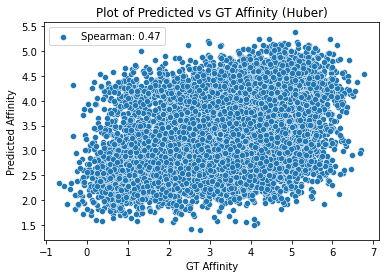

In [16]:
X_train, X_test, y_train_, y_test_, POIs_train, POIs_test = train_test_split(X, y, POIs, test_size=0.2, random_state=7)

huber_model = HuberRegressor()
huber_model.fit(X_train, y_train_)
y_pred = huber_model.predict(X_test)

r2_score = huber_model.score(X_test, y_test_)

spearman_corr, p_value = spearmanr(y_test_, y_pred)
print("Spearman Correlation:", spearman_corr)
print("Best Alpha:", ridge_model.alpha_)
print("R^2 Score:", r2_score)

sns.scatterplot(y_test_, y_pred, label=f"Spearman: {spearman_corr:.2f}")
plt.xlabel('GT Affinity')
plt.ylabel('Predicted Affinity')
plt.title(f"Plot of Predicted vs GT Affinity (Huber)")
plt.show()

### -----------------------------------------------------------------------------------------------

In [5]:
all_LCs, all_HCs = set(df.LC.unique()), set(df.HC.unique())

In [6]:
print(len(all_HCs), len(all_LCs))

48928 56043


In [8]:
num_mutations = 4
libr = 'AAYL52'
chain = 'L'
existing_chains = all_HCs if chain == 'H' else all_LCs

root_dir = ""
filename = os.path.join(root_dir, f"{libr}_{chain}_mutations_{num_mutations}.txt")
out_file = os.path.join(root_dir, f"{libr}_{chain}_mutations_{num_mutations}.fasta")

with open(filename) as f:
    mutated_seqs = f.read().splitlines()

i = 0
for seq in tqdm(mutated_seqs):
    if seq in existing_chains:
        print(f"skipping {seq}")
        continue
    with open(out_file, 'a') as g:
        g.write(f">{libr}_{chain}_{num_mutations}_mutations_{i}\n")
        g.write(seq+'\n')
        i += 1
    if i == 250000:
        break

  0%|          | 0/250000 [00:00<?, ?it/s]

## Predictions for New Generated Sequences

In [13]:
# Load the training (AlphaSeq) Data:
alphaseq_feats = np.concatenate((alphaseq_H_feats, alphaseq_L_feats), axis=-1)

X, y1, y2 = alphaseq_feats, mean_affins, ddgs
y1_bin_10 = [1 if a <= 1.0 else 0 for a in y1]
y1_bin_100 = [1 if a <= 2.0 else 0 for a in y1]
print("Dataset size:", X.shape, len(y1), len(y2))
print("Ratio of sub-10nM:", sum(y1_bin_10)/len(y1_bin_10))
print("Ratio of sub-100nM:", sum(y1_bin_100)/len(y1_bin_100))

Dataset size: (71834, 1024) 71834 71834
Ratio of sub-10nM: 0.05880223849430632
Ratio of sub-100nM: 0.1779797867305176


In [14]:
# Build the LinReg and 10nM, 100nM LogReg models
linreg_model = Ridge(alpha=0.01, max_iter=1000)
linreg_model_ddg = Ridge(alpha=0.01, max_iter=1000)
logreg_model_10 = LogisticRegression(C=10.0, max_iter=1000)
logreg_model_100 = LogisticRegression(C=10.0, max_iter=1000)

linreg_model.fit(X, y1)
linreg_model_ddg.fit(X, y2)
logreg_model_10.fit(X, y1_bin_10)
logreg_model_100.fit(X, y1_bin_100)

print("Done loading regression models!")

Done loading regression models!


In [ ]:
# Save the AbMAP features for new sequences:
from abmap import abmap_embed_batch

LIBRARY = "AAYL50"
chain = 'L'

device = 4
plm_type = 'esm1b'
alphaseq_inputs = ""
pretrained_path_H = ""
pretrained_path_L = ""
dev = torch.device(f'cuda:{device}' if torch.cuda.is_available() else "cpu")

abmap_H = abmap.load_abmap(pretrained_path=pretrained_path_H, plm_name=plm_type, device=device)
abmap_L = abmap.load_abmap(pretrained_path=pretrained_path_L, plm_name=plm_type, device=device)

output_dict = dict()
for nm in (3, 4):
    embeddings = []
    for i in tqdm(range(250000)):
        fname = f"{LIBRARY}_{chain}_{nm}_mutations_{i}.p"
        fname_ = os.path.join(alphaseq_inputs, fname)
        with open(fname_, 'rb') as p:
            input_embed = pickle.load(p).to(dev)
        input_embed = torch.unsqueeze(input_embed, 0)

        if LIBRARY in ["AAYL49", "AAYL51"]:
            abmap_model = abmap_H
        else:
            abmap_model = abmap_L

        with torch.no_grad():
            embedding = abmap_model.embed(input_embed, embed_type='fixed')
        embedding = torch.squeeze(embedding, 0)
        embeddings.append(embedding)

    all_features = torch.stack(embeddings, dim=0).detach().cpu().numpy()
    print(f"feature shape for sequences with {nm} mutations:", all_features.shape)
    output_dict[f"{LIBRARY}_{chain}_{nm}"] = all_features

save_dir = ""
with open(os.path.join(save_dir, f"{LIBRARY}_{chain}_features_{plm_type}.p"), 'wb') as f:
    pickle.dump(output_dict, f)

In [15]:
LIBRARY = "AAYL50"
CHAIN = "L"

device = 4
plm_type = 'esm1b'
alphaseq_inputs = ""
pretrained_path_H = ""
pretrained_path_L = ""
dev = torch.device(f'cuda:{device}' if torch.cuda.is_available() else "cpu")

abmap_H = abmap.load_abmap(pretrained_path=pretrained_path_H, plm_name=plm_type, device=device)
abmap_L = abmap.load_abmap(pretrained_path=pretrained_path_L, plm_name=plm_type, device=device)

# Load the AbMAP feature for un-mutated WT chain: (e.g. heavy chain for AAYL50)
if LIBRARY == "AAYL49":
    fname = "MIT_14_L.p"
    abmap_model = abmap_L
elif LIBRARY == "AAYL50":
    fname = "MIT_14_H.p"
    abmap_model = abmap_H
elif LIBRARY == "AAYL51":
    fname = "MIT_91_L.p"
    abmap_model = abmap_L
elif LIBRARY == "AAYL52":
    fname = "MIT_95_H.p"
    abmap_model = abmap_H
else:
    print("Wrong Library Name!")

fname_ = os.path.join(alphaseq_inputs, fname)
with open(fname_, 'rb') as p:
    input_embed = pickle.load(p).to(dev)
input_embed = torch.unsqueeze(input_embed, 0)
with torch.no_grad():
    embedding = abmap_model.embed(input_embed, embed_type='fixed')

if LIBRARY in ["AAYL50", "AAYL52"]:
    H_features = embedding.repeat(500000, 1).detach().cpu().numpy()
elif LIBRARY in ["AAYL49", "AAYL51"]:
    L_features = embedding.repeat(500000, 1).detach().cpu().numpy()
else:
    print("Wrong Library Name!!")

# Load the AbMAP features for new mutated sequences:
save_dir = ""
with open(os.path.join(save_dir, f"{LIBRARY}_{CHAIN}_features_esm1b.p"), 'rb') as f:
    data = pickle.load(f)
    features_3mut, features_4mut = data[f"{LIBRARY}_{CHAIN}_3"], data[f"{LIBRARY}_{CHAIN}_4"]
    
    if LIBRARY in ["AAYL50", "AAYL52"]:
        L_features = np.concatenate((features_3mut, features_4mut), axis=0)
    elif LIBRARY in ["AAYL49", "AAYL51"]:
        H_features = np.concatenate((features_3mut, features_4mut), axis=0)
    else:
        print("Wrong Library Name!!!")

newseq_features = np.concatenate((H_features, L_features), axis=-1)
print(newseq_features.shape)

esm1b loaded to cuda:4


Using cache found in /afs/csail.mit.edu/u/c/chihoim/.cache/torch/hub/facebookresearch_esm_main


Loaded the Pre-trained Model!
esm1b loaded to cuda:4


Using cache found in /afs/csail.mit.edu/u/c/chihoim/.cache/torch/hub/facebookresearch_esm_main


Loaded the Pre-trained Model!
(500000, 1024)


In [16]:
id_list = [(3, a) for a in range(250000)] + [(4, a) for a in range(250000, 500000)]
print(len(id_list))

500000


In [17]:
# perform predictions here:

pred_prob_10 = logreg_model_10.predict_proba(newseq_features)[:, 1]
pred_prob_100 = logreg_model_100.predict_proba(newseq_features)[:, 1]

min_list = [min(x, y) for x, y in zip(pred_prob_10, pred_prob_100)]

pred_affin = linreg_model.predict(newseq_features)
pred_ddg = linreg_model_ddg.predict(newseq_features)

In [29]:
sorted_minprob = sorted(zip(min_list, id_list), key=lambda x: x[0], reverse=True)
sorted_affin = sorted(zip(pred_affin, id_list), key=lambda x: x[0])
sorted_ddg = sorted(zip(pred_ddg, id_list), key=lambda x: x[0])

k=5000
idx_minprob = [t[1] for t in sorted_minprob][:k]
idx_affin = [t[1] for t in sorted_affin][:k]
idx_ddg = [t[1] for t in sorted_ddg][:k]

# for NEGATIVE ONLY!!!
idx_minprob = [t[1] for t in sorted_minprob][-k:]
idx_affin = [t[1] for t in sorted_affin][-k:]
idx_ddg = [t[1] for t in sorted_ddg][-k:]

overlap = list(set(idx_minprob) & set(idx_affin) & set(idx_ddg))
print(len(overlap))

983


In [30]:
# retrieve the idxs for each n-mutation
idx_3mut = sorted([b for (a, b) in overlap if a == 3])
idx_4mut = sorted([b for (a, b) in overlap if a == 4])

selected_3mut_feats = newseq_features[idx_3mut]
selected_4mut_feats = newseq_features[idx_4mut]

print(selected_3mut_feats.shape, selected_4mut_feats.shape)

(198, 1024) (785, 1024)


In [31]:
# perform k-means clustering here:
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import pairwise_distances_argmin_min

X = selected_4mut_feats
n_clus = 6

# Create an instance of KMeans
kmeans = KMeans(n_clusters=n_clus, random_state=42)

# Fit the model to the data
kmeans.fit(X)
X_ = kmeans.fit_transform(X)

# Get the cluster labels for each data point
labels = kmeans.labels_

# Get the cluster centers
cluster_centers = kmeans.cluster_centers_

# Calculate the medoid for each cluster
medoids = []
medoid_indices = []  # List to store the indices of the medoids

for cluster_label in range(kmeans.n_clusters):
    # Get the data points belonging to the current cluster
    cluster_data = X[labels == cluster_label]

    # Compute the pairwise distances between cluster_data and the centroid
    distances = pairwise_distances_argmin_min(cluster_data, [cluster_centers[cluster_label]])

    # Get the index of the medoid (data point with minimum distance to the centroid)
    medoid_index = np.argmin(distances[1])
    original_index = np.where(labels == cluster_label)[0][medoid_index]

    # Get the medoid data point
    medoid = cluster_data[medoid_index]

    # Add the medoid to the list
    medoids.append(medoid)
    medoid_indices.append(original_index)

(array([130.,   0., 199.,   0., 158.,   0.,  92.,   0.,  91., 115.]),
 array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. ]),
 <BarContainer object of 10 artists>)

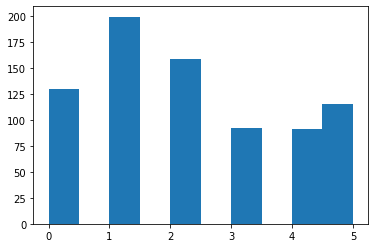

In [32]:
plt.hist(kmeans.labels_)

In [29]:
# for seqs with 3 mutations:

candidate_idxs = [idx_3mut[mi] for mi in medoid_indices]

print(candidate_idxs)

num_gen = 4
candidate_pred_affins = pred_affin[candidate_idxs]
affin_idx_pairs_ = sorted(zip(candidate_pred_affins, candidate_idxs, medoids), key=lambda x: x[0])
affin_idx_pairs, sorted_medoids = [(a,b) for a, b, _ in affin_idx_pairs_], [c for _, _, c in affin_idx_pairs_]

# for NEGATIVE ONLY!!!
affin_idx_pairs_ = sorted(zip(candidate_pred_affins, candidate_idxs, medoids), key=lambda x: x[0], reverse=True)
affin_idx_pairs, sorted_medoids = [(a,b) for a, b, _ in affin_idx_pairs_], [c for _, _, c in affin_idx_pairs_]

print("affinity, index pairs:", affin_idx_pairs[:num_gen])

# gather medoids here:
medoids_feat = np.stack(sorted_medoids[:num_gen])
print("medoids:", medoids_feat.shape)

seqs_all = []
seqs_root_dir = ""
for record in SeqIO.parse(os.path.join(seqs_root_dir, f"{LIBRARY}_{CHAIN}_mutations_3.fasta"), "fasta"):
    seqs_all.append(str(record.seq))
print(len(seqs_all))
for _, i in affin_idx_pairs[:num_gen]:
    print(seqs_all[i])

[170434, 137636, 15383, 150227]
affinity, index pairs: [(4.8343306, 170434), (4.726301, 15383), (4.607621, 150227), (4.3602266, 137636)]
medoids: (4, 1024)
250000
DVVMTQSPESLAVSLGERATISCKSSQSVLYESRNKNSRIWYQQKAGQPPKLLIYWASTRESGVPDRFSGSGSGTDFTLTISSLQAEDAAVYYCQQYHRLPTSFGGGTKVEIK
DVVMTQSPESLAVSLGERATISCKSSQSVLYESRNKNSVVWYQQKAGQPPKLLIYWASTREGGVPDRFSGSGSGTDFTLTISSLQAEDAAVYYCTQYHRLPLSFGGGTKVEIK
DVVMTQSPESLAVSLGERATISCKSSQSVLYESRNKNFDAWYQQKAGQPPKLLIYWYSTRESGVPDRFSGSGSGTDFTLTISSLQAEDAAVYYCQQYHRLPLSFGGGTKVEIK
DVVMTQSPESLAVSLGERATISCKSSQSVLYECRNKNSVMWYQQKAGQPPKLLIYWISTRESGVPDRFSGSGSGTDFTLTISSLQAEDAAVYYCQQYHRLPLSFGGGTKVEIK


In [33]:
# for seqs with 4 mutations:

candidate_idxs = [idx_4mut[mi] for mi in medoid_indices]

print(candidate_idxs)

num_gen = 4
candidate_pred_affins = pred_affin[candidate_idxs]
affin_idx_pairs_ = sorted(zip(candidate_pred_affins, candidate_idxs, medoids), key=lambda x: x[0])
affin_idx_pairs, sorted_medoids = [(a,b) for a, b, _ in affin_idx_pairs_], [c for _, _, c in affin_idx_pairs_]

# for NEGATIVE ONLY!!!
affin_idx_pairs_ = sorted(zip(candidate_pred_affins, candidate_idxs, medoids), key=lambda x: x[0], reverse=True)
affin_idx_pairs, sorted_medoids = [(a,b) for a, b, _ in affin_idx_pairs_], [c for _, _, c in affin_idx_pairs_]

print("affinity, index pairs:", affin_idx_pairs[:num_gen])

# gather medoids here:
medoids_feat = np.stack(sorted_medoids[:num_gen])
print("medoids:", medoids_feat.shape)

seqs_all = []
seqs_root_dir = ""
for record in SeqIO.parse(os.path.join(seqs_root_dir, f"{LIBRARY}_{CHAIN}_mutations_4.fasta"), "fasta"):
    seqs_all.append(str(record.seq))
print(len(seqs_all))
for _, i in affin_idx_pairs[:num_gen]:
    print(seqs_all[i-250000])

[275724, 276023, 337485, 494830, 327195, 324099]
affinity, index pairs: [(4.891387, 494830), (4.6885996, 276023), (4.474758, 327195), (4.434973, 275724)]
medoids: (4, 1024)
250000
DVVMTQSPESLAVSLGERATISCKSSQSVLYVSRNKNSPLWYQQKAGQPPKLLIYWASGRESGVPDRFSGSGSGTDFTLTISSLQAEDAAVYYCQQYHRLPLSFGGGTKVEIK
DVVMTQSPESLAVSLGERATISCKSSQSVLYESRFKNSDLWYQQKAGQPPKLLIYWASTRESGVPDRFSGSGSGTDFTLTISSLQAEDAAVYYCQQYHRLPCSFGGGTKVEIK
DVVMTQSPESLAVSLGERATISCKSSQSVLYESRNKNSVCWYQQKAGQPPKLLIYWFSTRESGVPDRFSGSGSGTDFTLTISSLQAEDAAVYYCYQCHRLPLSFGGGTKVEIK
DVVMTQSPESLAVSLGERATISCKSSQVVLYESRNKNSRAWYQQKAGQPPKLLIYWNSTRGSGVPDRFSGSGSGTDFTLTISSLQAEDAAVYYCQQYHRLPLSFGGGTKVEIK


### UMAP Projection of New Sequence Embeddings

In [35]:
library = 'AAYL50'
indices = [i for i, element in enumerate(POIs) if library in element]
alphaseq_feats_lib = alphaseq_feats[indices]
mean_affins_lib = mean_affins[indices]
print("Dataset size:", alphaseq_feats_lib.shape, mean_affins_lib.shape)

Dataset size: (18708, 1024) (18708,)


In [36]:
# a umap projection of the sequence space:
import umap
reducer = umap.UMAP()

umap_proj_alphaseq = reducer.fit_transform(alphaseq_feats_lib)
print(umap_proj_alphaseq.shape)

(18708, 2)


In [28]:
pos_cand = medoids_feat

In [34]:
neg_ctrl = medoids_feat

In [37]:
# a umap projection of the candidate/neg ctrl sequences:
X_WT = np.concatenate((WT_embed, pos_cand, neg_ctrl), axis=0)
X_WT_labels = ["WT", "candidate", "candidate", "candidate", "candidate",
               "neg_ctrl", "neg_ctrl", "neg_ctrl", "neg_ctrl"]
umap_proj = reducer.transform(X_WT)
umap_proj.shape

(9, 2)

In [33]:
# add WT here
X_WT = np.concatenate((X, WT_embed), axis=0)

umap_proj = reducer.transform(X_WT)
umap_proj.shape

(1287, 2)

Text(0.5, 1.0, 'UMAP projection of Sequences with Unseen Mutations (n=4)')

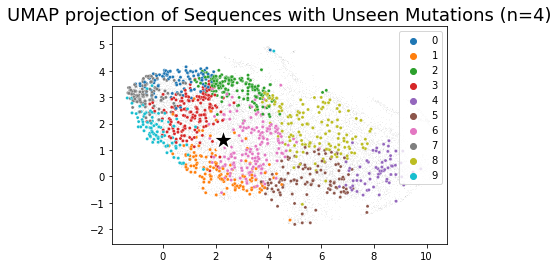

In [35]:
# plt.scatter(umap_proj_alphaseq[:, 0], umap_proj_alphaseq[:, 1], s=1, c=mean_affins_lib,
#                 cmap=sns.color_palette("seismic", as_cmap = True))
sns.scatterplot(x=umap_proj_alphaseq[:, 0], y=umap_proj_alphaseq[:, 1], s = 1, alpha=0.1, color='gray')
sns.scatterplot(x=umap_proj[:-1, 0], y=umap_proj[:-1, 1], hue=labels, s=10, palette='tab10')
sns.scatterplot(x=umap_proj[-1:, 0], y=umap_proj[-1:, 1], marker="*", s=500, color='black')

plt.gca().set_aspect('equal', 'datalim')
# plt.colorbar()
# plt.title(f"UMAP projection of AlphaSeq {LIBRARY} (n=3)", fontsize=18)
plt.title('UMAP projection of Sequences with Unseen Mutations (n=4)', fontsize=18)

Text(0.5, 1.0, 'UMAP projection of Candidate/Neg-Ctrl Sequences (n=4)')

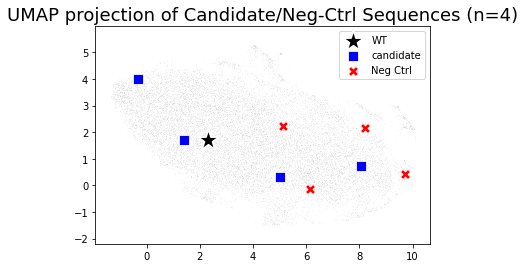

In [38]:
sns.scatterplot(x=umap_proj_alphaseq[:, 0], y=umap_proj_alphaseq[:, 1], s = 1, alpha=0.1, color='gray')
sns.scatterplot(x=umap_proj[:1, 0], y=umap_proj[:1, 1], marker="*", s=500, color='black', label='WT')
sns.scatterplot(x=umap_proj[1:5, 0], y=umap_proj[1:5, 1], marker="s", s=100, color='blue', label='candidate')
sns.scatterplot(x=umap_proj[5:, 0], y=umap_proj[5:, 1], marker="X", s=100, color='red', label='Neg Ctrl')

plt.gca().set_aspect('equal', 'datalim')
plt.legend()
# plt.colorbar()
plt.title('UMAP projection of Candidate/Neg-Ctrl Sequences (n=4)', fontsize=18)